
<h1><center>Trends In Forest Recovery After Stand Replacing Disturbance: A Spectrotemporal Evaluation Of Productivity In Southeastern Pine Forests</center></h1>

<h4><center> Daniel J. Putnam </center></h4>

<center> For partial fulfillment of the reqiurements for the Master of Science degree </center>
<center> College of Natural Resources and Environment </center>
<center> Virginia Polytechnic Institute and State University </center>


## ------------------------------------COLLECTION 2 INVESTIGATION-------------------------------------------

## Analysis Preperation

### _Libraries_

In [1]:
import geemap
import ee
import folium
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import Image
from datetime import datetime
ee.Initialize()

In [2]:
#ee.Authenticate(auth_mode='paste')
#ee.Authenticate()

### _Imports_

In [3]:
LS5 = ee.ImageCollection("LANDSAT/LT05/C02/T1_L2") # landsat 5
LS7 = ee.ImageCollection("LANDSAT/LE07/C02/T1_L2") # landsat 7
LS8 = ee.ImageCollection("LANDSAT/LC08/C02/T1_L2") # landsat 8
LCMS = ee.ImageCollection("USFS/GTAC/LCMS/v2021-7") # landscape Change Monitoring System
NLCD_col = ee.ImageCollection("USGS/NLCD_RELEASES/2019_REL/NLCD") # national landcover Database
loblolly = ee.FeatureCollection("users/dputnam21/us_eco_l3_NEW")

### _Priliminary set-up_

In [4]:
# Creating sample date range for disturbances
startingD = ee.Date.fromYMD(1989,1,1)
endingD = ee.Date.fromYMD(2011,12,31)

### _Landsat Preprocessing_

In [5]:
# Cloud masking based on the QA band : code taken from landsat example in data catalog in GEE
def LScloudMask(image):
  qa = image.select('QA_PIXEL')
    # removing cloud pixels if confiance is high, cloud shadow, snow
  cloud = qa.bitwiseAnd(1 << 3).And(qa.bitwiseAnd(1 << 9)) \
            .Or(qa.bitwiseAnd(1 << 4)) \
            .Or(qa.bitwiseAnd(1 << 5))
  return image.updateMask(cloud.Not())

## A function that applies scaling factors and offsets : code taken from landsat example in data catalog in GEE
def applyScaleFactors(image):
  opticalBands = image.select(ee.List.sequence(0,10)).multiply(0.0000275).add(-0.2)
  return image.addBands(opticalBands, None, True)

# Going to try removing the coverage overlap between LS5 and LS8 to try and fix some issues
#LS5 = LS5.filterDate(start = '1984-01-01',opt_end = ee.Date('2013-04-11'))
#LS8 = LS8.filterDate(start = ee.Date('2013-04-11'))

# adding the cloud mask per generation
LS5 = LS5.map(LScloudMask)
LS7 = LS7.map(LScloudMask)
LS8 = LS8.map(LScloudMask)

# applying scaling factors
LS5 = LS5.map(applyScaleFactors)
LS7 = LS7.map(applyScaleFactors)
LS8 = LS8.map(applyScaleFactors)

# Lansat 5/7 & 8 differ in their band labeling, need to select the bands I'm going to use and rename them to
# match each other before merging collections : bands I need [red,green,NIR,SWIR1,SWIR2]    
LS8BandNames = ee.List(['SR_B4','SR_B3','SR_B5','SR_B6','SR_B7','QA_PIXEL'])
NewBandNames = ee.List(['SR_B3','SR_B2','SR_B4','SR_B5','SR_B7','QA_PIXEL'])
LS8 = LS8.select(LS8BandNames,NewBandNames)

# merging the landsat 5 and 7 collections
LS_stack = LS5.merge(LS8)
LS_stack = LS_stack.merge(LS7)

# data reduction on the image stack
LS_stack = LS_stack.filterBounds(loblolly)

In [6]:
# defining and adding vegetation indicies to landsat collection

# Adding a function to calculate and add an NDVI band for a single image
def addNDVI(image):
  ndvi = image.normalizedDifference(['SR_B4', 'SR_B3']).rename('NDVI')
  return image.addBands(ndvi)

# Adding a function to calculate and add an NBR band for a single image.
def addNBR(image):
  nbr = image.normalizedDifference(['SR_B4', 'SR_B7']).rename('NBR')
  return image.addBands(nbr)

# Adding a function to calculate and add an MBI band for a single image.
def addMBI(image):
  MBI = image.expression(
  "MBI = ((b('SR_B5') - b('SR_B7') - b('SR_B4')) / (b('SR_B5') + b('SR_B7') + b('SR_B4'))) + 0.5")
  return image.addBands(MBI)

# Adding a function to calculate and add an EVI2 band for a single image.
def addEVI2(image):
  EVI2 = image.expression(
  "EVI2 = 2.5 * ( b('SR_B4') - b('SR_B3') ) / ( b('SR_B4') + ( 2.4 * b('SR_B3')) + 1)")
  return image.addBands(EVI2)

# Adding the indices to the filtered combined Landsat collection
LS_stack_wVI = LS_stack.map(addNDVI)
LS_stack_wVI = LS_stack_wVI.map(addNBR)
LS_stack_wVI = LS_stack_wVI.map(addMBI)
LS_stack_wVI = LS_stack_wVI.map(addEVI2)

---

## Stand Identification Methods

### _Landcover/Landuse Mask_

In [7]:
# New NLCD/LCMS method
# retrieve NLCD for each year
NLCD_2001 = NLCD_col.filter(ee.Filter.eq('system:index', '2001')).first().select("landcover")
NLCD_2004 = NLCD_col.filter(ee.Filter.eq('system:index', '2004')).first().select("landcover")
NLCD_2006 = NLCD_col.filter(ee.Filter.eq('system:index', '2006')).first().select("landcover")
NLCD_2008 = NLCD_col.filter(ee.Filter.eq('system:index', '2008')).first().select("landcover")
NLCD_2011 = NLCD_col.filter(ee.Filter.eq('system:index', '2011')).first().select("landcover")
NLCD_2013 = NLCD_col.filter(ee.Filter.eq('system:index', '2013')).first().select("landcover")
NLCD_2016 = NLCD_col.filter(ee.Filter.eq('system:index', '2016')).first().select("landcover")
NLCD_2019 = NLCD_col.filter(ee.Filter.eq('system:index', '2019')).first().select("landcover")

# combine NLCD to image collection
NLCDlandcover_col = ee.ImageCollection(ee.List([NLCD_2001,NLCD_2004,NLCD_2006,NLCD_2008,NLCD_2011,NLCD_2013,NLCD_2016,NLCD_2019]))

# Function to remap NLCD classes of interest for conditional layer
def remapNLCD(image):
    image = ee.Image(image)
    image = image.updateMask(ee.Image.constant(42).Or(ee.Image.constant(52)))
    image = image.remap(ee.List([42,52]),ee.List([10,1]),defaultValue = None)
    return image

# Layer containing the summed values of pixels across the collection after remapping
NLCDclassSum = NLCDlandcover_col.map(remapNLCD).reduce(ee.Reducer.sum())
NLCDMask = NLCDclassSum.remap(ee.List([62,71,80]),ee.List([1,1,1]), defaultValue = None)

# retrieve LCMS landuse classification
LCMSlanduseCol = LCMS.select("Land_Use")

# A function to select only forest landuse class
def remapLCMS(image):
    image = ee.Image(image)
    onlyForest = image.remap([3],[1], defaultValue = None)
    return onlyForest

LCMSlanduseSum = LCMSlanduseCol.map(remapLCMS).reduce(ee.Reducer.sum())

# # combining the two layers into a landuse / landcover mask
lulcMask = NLCDMask.updateMask(LCMSlanduseSum.gte(36))
lulcMask = lulcMask.clip(loblolly) # clip mask to study boundaries for better loading

### _LCMS Fast change method_

In [8]:
# Using the LCMS Change metric to identify harvest areas in contrast to the max VI method
# Filtering LCMS for the region and timeframe
LCMSchange = LCMS.select('Change_Raw_Probability_Fast_Loss')

def LCMSchangeSelection(image):
    image = ee.Image(image)
    minConfidence = 70
    gtePercent = image.gte(ee.Image.constant(minConfidence))
    gtePercent = gtePercent.updateMask(gtePercent.eq(1))
    gtePercent = gtePercent.set({'year':image.date().get('year')})
    outImage = gtePercent.updateMask(lulcMask).rename('remapped')
    return outImage

# applying the function to the LCMS
FC_stack = LCMSchange.map(LCMSchangeSelection)

### _Connected Pixel (Min stand size) mask_

In [9]:
# A function to apply a connected pixel mask to the input image
def conectPixls(InImage,minArea,maxPixels):
    pixelCount = InImage.connectedPixelCount(maxPixels,False)
    minPixelCount = ee.Image(minArea).divide(ee.Image.pixelArea())
    outImage = InImage.updateMask(pixelCount.gte(minPixelCount))
    return outImage

# a function to be mapped accross an image collection and annually apply the connected pixels mask, also creates an
# additional band to store the year of disturbance for each pixel
def annualConectPixls(image):
    conectPixlsMasked = conectPixls(image,40000,1024) # minimum stand size of 4 ha (represented in m3), maximum of 92 ha (represented in pixel count) (tool limit)
    imgYear = image.get('year')
    imgYearBand = ee.Image.constant(imgYear).uint16().rename('ChangeY')
    imgYearBand = imgYearBand.updateMask(conectPixlsMasked)
    return conectPixlsMasked.addBands(imgYearBand)

FC_final = FC_stack.map(annualConectPixls)

In [10]:
# creating the summary images
FC_final_changeN = FC_final.select('remapped').reduce(ee.Reducer.sum())
FC_final_firstYear = FC_final.select('ChangeY').reduce(ee.Reducer.min())
FC_final_lastYear = FC_final.select('ChangeY').reduce(ee.Reducer.max())

### _Disturbance Year mask_

In [11]:
# Going to help to keep detected disturbances within a given window of time
# first detected disturbance
FC_final_changeN = FC_final_changeN.updateMask(FC_final_firstYear.gte(startingD.get('year')) \
                                               .And(FC_final_firstYear.lte(endingD.get('year')))
                                              )
# last detected disturbance
FC_final_changeN = FC_final_changeN.updateMask(FC_final_lastYear.gte(startingD.get('year')) \
                                               .And(FC_final_lastYear.lte(endingD.get('year')))
                                              )


In [12]:
# Final potential sample pixels
# An image representing pixels that meet all selection criteria
potentialSamples = ee.Image.toUint8(FC_final_changeN.updateMask(FC_final_changeN.eq(1))).rename('remapped_sum')

### _Filter Selection to Only Include Homogenous, Non-Edge Groups of Pixels_

In [13]:
# Edge avoidence
PS_connectedPixelCount = potentialSamples.reduceNeighborhood(ee.Reducer.count(),
                                                             ee.Kernel.circle(2, 'pixels', False, 1),
                                                             'mask',
                                                             True
                                                            )
potentialSamples2 = potentialSamples.updateMask(PS_connectedPixelCount.gte(13))

---

## Automatic Stand Selection Method

### _Creating Sampling Areas Using Ecoregions_

In [14]:
# Function to convert the ecoregion code to an integer value
def convertPropertyToBand(feat):
    feat = ee.Feature(feat)
    prop = feat.get('US_L3CODE')
    propInt = ee.Number.parse(prop).toInt()
    feat = feat.set({'numericL3ecocode':propInt})
    return feat
loblolly = loblolly.map(convertPropertyToBand)

# Need to convert ecoregion feature collection and the property to integer in order for it to be used 
#     as the 'classBand' in the stratifiedSample fucntion
ecoregionImage = ee.Image(loblolly.reduceToImage(['numericL3ecocode'],ee.Reducer.first()))
ecoregionImage = ecoregionImage.cast({'first':'uint8'})
ecoregionImage = ecoregionImage.clipToCollection(loblolly)

# (old method), want to just export a single band
# Adding ecoregion code as band to potential sample pixels
#potentialSamples2 = potentialSamples2.addBands(ecoregionImage.select('first').rename('numericL3ecocode'))

potentialSamples2 = ecoregionImage.select('first').rename('numericL3ecocode').updateMask(potentialSamples2)

### _Imports/Exports of Created Data_

In [15]:
## today's date
today = str(datetime.now()).split(" ")[0]
today = today.replace("-","_")
today = "_"+today
print(today)

_2022_09_23


In [16]:
# Exporting the points created in the above cell to google drive (only way they will finish processing)
# The export process will take about 15 minutes to complete
#geemap.ee_export_vector_to_drive(samplePoints, 'EE_SamplePoints'+today, 'EarthEngine_Exports', file_format='shp', selectors=None)

In [17]:
# # Importing the points created in the above cell
# samplePoints = ee.FeatureCollection('users/dputnam21/stratifiedSamplePoints_03022022')

In [18]:
# Importing points created in arcpro
samplePoints = ee.FeatureCollection('users/dputnam21/samplePoints_06282022')

In [19]:
# # Running a batch export process to export the final potential samples raster
# exportTask = ee.batch.Export.image.toDrive(image = potentialSamples2, 
#                                            description = 'PotentialSamples'+today, 
#                                            folder = 'EarthEngine_Exports', 
#                                            region = loblolly.geometry(), 
#                                            scale = 30, 
#                                            skipEmptyTiles = True,
#                                            maxPixels = 3000000000,
#                                            fileFormat = 'GeoTIFF', 
#                                            )
# exportTask.start()

In [20]:
# Importing raster of potential samples batch exported in above cell
# potentialSamples2 = ee.Image('users/dputnam21/PotentialSamples_2022_06_14')

---

### _Creating Random Sample Points_

In [21]:
# Going to try just using the export table function to drive
# samplePoints = potentialSamples2.stratifiedSample(numPoints = 50,
#                                                  classValues = [34,35,45,63,64,65,66,67,68,71,73,74,75],
#                                                  classPoints = [2,404,391,148,1,799,5,40,36,4,1,61,114],
#                                                  region = loblolly,
#                                                  classBand = 'b1',
#                                                  scale = 30,
#                                                  seed = 5,
#                                                  dropNulls = True,
#                                                  geometries = True,
#                                                  )

### _Creating Point Buffers for Sampling_

In [22]:
# reduction in the number of samplepoints for methodology testing
sampleLimit = samplePoints.size().getInfo() # can change this to a number for testing purposes
samplePoints2 = samplePoints.limit(ee.Number(sampleLimit),
                                   'UniqueID',
                                   True
                                  )
numSamples = samplePoints2.size().getInfo()

In [23]:
# defining a function to be mapped over point feature collection to create buffers
def makeBuffers(feat):
    inFeat = ee.Feature(feat)
    buff = inFeat.buffer(distance = 60) # 60 meter buffer = 2 pixel radius to align with circlular kernel mask
    return buff

sampleCircles = samplePoints2.map(makeBuffers)

### Displaying images on the map

In [56]:
# LCMS landcover palette
LCMSlcPalette = ['efff6b','ff2ff8','1b9d0c','97ffff','a1a1a1','c2b34a','1B1716']

Map = geemap.Map(basemap="SATELLITE")
#Map.centerObject(loblolly,7)
Map.centerObject(ee.Feature(ee.Geometry.Point([-77.2013,36.8497, ])),13)

# This is the bottom of the layer order

Map.addLayer(ee.Image().paint(loblolly, color = 'black',width = 3), name = 'ecoRegion Outlines')
Map.addLayer(ecoregionImage.select('first'), vis_params = {'palette': LCMSlcPalette, 'min': 45, 'max':75}, name = 'Ecoregion Code Image',shown = False)
Map.addLayer(NLCDMask, vis_params = {'palette': ['3182BD'],'min':1,'max':1}, name = 'NLCD Mask', shown = False)
Map.addLayer(lulcMask, vis_params = {'palette': ['3C4856'],'min':1,'max':1}, name = 'LCMS + NLCD landcover mask', shown = False)
Map.addLayer(FC_stack, vis_params = {'palette': ['B56285'],'min':0,'max':1}, name = 'FC (>70%) raw', shown = False)
Map.addLayer(FC_final.select('remapped'), vis_params = {'palette': ['9FACBD'],'min':0,'max':1}, name = 'FC (>70%) Min Area', shown = False)
Map.addLayer(FC_final_changeN,{'palette':['fee0d2','fc9272','de2d26'],'min':1,'max':5},'LCMS Fast Change Count',True)
Map.addLayer(FC_final_firstYear,{'palette':['edf8b1','7fcdbb','2c7fb8'],'min' : 1995, 'max' : 2010},'LCMS Fast Change Year',False)
Map.addLayer(potentialSamples2.select('numericL3ecocode'),{'palette':['7E3054'],'min':0,'max':1}, name = 'Potential Samples 2', shown = True)
Map.addLayer(samplePoints,{'color':'blue'}, name = 'Stratified Random Samples',shown = True)

# This is the top of the layer order

# Adding a legend for exporting images of layers
legend_keys = ['Final Potential Sample Pixels', 'Edge Pixels Removed']
# colorS can be defined using either hex code or RGB (0-255, 0-255, 0-255)
legend_colors = ['de2d26','fee0d2']

Map.add_legend(
    legend_keys=legend_keys, legend_colors=legend_colors, position='bottomright'
)

Map.addLayerControl()
Map

Map(center=[36.8497, -77.2013], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=HBox(ch…

---

## Automatic Stand Selection Method

### _Export of stand attributes & Environmental Variables_

In [ ]:
# Import of environmental data
elevation_image = ee.Image("USGS/3DEP/10m").select('elevation')
soilTexture_image = ee.Image("OpenLandMap/SOL/SOL_TEXTURE-CLASS_USDA-TT_M/v02")
soilGG = ee.Image("OpenLandMap/SOL/SOL_GRTGROUP_USDA-SOILTAX_C/v01")
phenology_col = ee.ImageCollection("MODIS/006/MCD12Q2")
soilPh = ee.Image("OpenLandMap/SOL/SOL_PH-H2O_USDA-4C1A2A_M/v02")

forestOwnership = ee.Image('users/dputnam21/Butler2017Ownership')
forestOwnership = forestOwnership.rename(['ownership'])

# Creating topography variables from the elevation layer
topography = ee.Terrain.products(elevation_image)

In [ ]:
# Going to bin aspect values into 8 classes for better processing
# Remap values.
aspect = topography.select('aspect')
binnedAspect = ee.Image(1) \
.where(aspect.gt(337.5).And(aspect.lte(22.5)), 1) \
.where(aspect.gt(22.5).And(aspect.lte(67.5)), 2) \
.where(aspect.gt(67.5).And(aspect.lte(112.5)), 3) \
.where(aspect.gt(112.5).And(aspect.lte(157.5)), 4) \
.where(aspect.gt(157.5).And(aspect.lte(202.5)), 5) \
.where(aspect.gt(202.5).And(aspect.lte(247.5)), 6) \
.where(aspect.gt(247.5).And(aspect.lte(292.5)), 7) \
.where(aspect.gt(292.5).And(aspect.lte(337.5)), 8)

In [ ]:
years = ee.List.sequence(1984, 2021)

In [ ]:
### GRIDMET Processing ###
climate_col = ee.ImageCollection("IDAHO_EPSCOR/GRIDMET")
climate_col = climate_col.filter(ee.Filter.calendarRange(1984,2021,'year'))
baseTemp = (5.5) # degrees celcius at which loblolly pine growth stops

# Function to calculated GDD for each day
def calcGDD(singleDayImage):
    singleDayImage = ee.Image(singleDayImage) 
    maxTemp = singleDayImage.select('tmmx').subtract(273.15)
    minTemp = singleDayImage.select('tmmn').subtract(273.15)
    GDD1 = maxTemp.add(minTemp)
    GDD2 = GDD1.divide(2)
    GDD3 = GDD2.subtract(baseTemp)
    GDD4 = GDD3.rename('GDD')
    GDD5 = GDD4.set('system:time_start',maxTemp.get('system:time_start'))
    return singleDayImage.addBands(GDD5)

# Function to calculate cumulative growing degree days for each year
def calcCumulativeGDD(year):
    singleYear_col = climate_col.select('GDD').filter(ee.Filter.calendarRange(year, year, 'year'))
    cumulativeGDD = singleYear_col.sum()
    cumulativeGDD = cumulativeGDD.set('system:time_start', ee.Date.fromYMD(year,1, 1).millis())
    return cumulativeGDD

# Function to identify below freezing days
def calcFreezeDays(singleDayImage):
    singleDayImage = ee.Image(singleDayImage)
    minTemp = singleDayImage.select('tmmn').subtract(273.15)
    freeze = minTemp.updateMask(minTemp.lte(0))
    return singleDayImage.addBands(freeze.rename('below_0'))

# Calculate total number of below freezing days per year
def annualFreezeDays(year):
    singleYear_col = climate_col.select('below_0').filter(ee.Filter.calendarRange(year, year, 'year'))
    below0_count = singleYear_col.reduce(ee.Reducer.count())
    below0_count = below0_count.set('system:time_start', ee.Date.fromYMD(year,1, 1).millis())
    return below0_count

# Creating average temperature and vapor pressure deficit values for growing season months
def calcGrowingSeasonVars(year):
    singleYear_col = climate_col.filterDate(ee.Date.fromYMD(year,3,1),ee.Date.fromYMD(year,10,31))
    maxTemp = singleYear_col.select('tmmx').mean().subtract(273.15)
    minTemp = singleYear_col.select('tmmn').mean().subtract(273.15)
    avgTemp1 = maxTemp.add(minTemp)
    avgTemp2 = avgTemp1.divide(2)
    avgTemp2 = avgTemp2.set('system:time_start', ee.Date.fromYMD(year,7, 1).millis())
    avgTemp2 = avgTemp2.rename('AVGgrowSZNtemp')
    avgVPD = singleYear_col.select('vpd').mean()
    avgVPD = avgVPD.set('system:time_start', ee.Date.fromYMD(year,7, 1).millis())
    avgVPD = avgVPD.rename('AVGgrowSZNvpd')
    totalPrecip = singleYear_col.select('pr').sum()
    totalPrecip = totalPrecip.set('system:time_start', ee.Date.fromYMD(year,7, 1).millis())
    totalPrecip = totalPrecip.rename('TotalgrowSZNprecip')
    avgVPD = avgVPD.addBands(totalPrecip)
    return avgTemp2.addBands(avgVPD)

climate_col = climate_col.map(calcGDD)
climate_col = climate_col.map(calcFreezeDays)

GDD_col = ee.ImageCollection(years.map(calcCumulativeGDD))
freeze_col = ee.ImageCollection(years.map(annualFreezeDays))
growSZN_col = ee.ImageCollection(years.map(calcGrowingSeasonVars))

In [ ]:
# looking at potential changes over time
GDD1984 = GDD_col.filter(ee.Filter.calendarRange(1984, 1989, 'year')).mean()
GDD2021 = GDD_col.filter(ee.Filter.calendarRange(2016, 2021, 'year')).mean()
GDDChange = ee.Image(GDD2021.subtract(GDD1984))

freeze1984 = freeze_col.filter(ee.Filter.calendarRange(1984, 1989, 'year')).mean()
freeze2021 = freeze_col.filter(ee.Filter.calendarRange(2016, 2021, 'year')).mean()
freezeChange = ee.Image(freeze2021.subtract(freeze1984))

growSZN1984 = growSZN_col.filter(ee.Filter.calendarRange(1984, 1989, 'year')).mean()
growSZN2021 = growSZN_col.filter(ee.Filter.calendarRange(2016, 2021, 'year')).mean()
growSZNChange = ee.Image(growSZN2021.subtract(growSZN1984))

In [ ]:
import geemap.colormaps as cm
Map2 = geemap.Map(basemap="SATELLITE")
Map2.centerObject(loblolly,5)

aspectPalette = ['#ffffcc','#ffeda0','#fed976','#feb24c','#fd8d3c','#fc4e2a','#e31a1c','#b10026']
soilPalette = ['#d5c36b','#b96947','#9d3706','#ae868f','#f86714','#46d143','#368f20','#3e5a14','#ffd557','#fff72e','#ff5a9d','#ff005b']
soilPhPalette = ["FF0000","FF1C00","FF3900","FF5500","FF7100","FF8E00","FFAA00","FFC600","FFE200","FFFF00","E3FF00","C7FF00","AAFF00","8EFF00","72FF00","55FF00","39FF00","1DFF00","01FF00","00FF1C","00FF38","00FF54","00FF71","00FF8D","00FFA9","00FFC6","00FFE2","00FFFE","00E3FF","00C7FF","00ABFF","008FFF","0072FF","0056FF","003AFF","001DFF","0001FF","1B00FF","3800FF","5400FF"]
Map2.addLayer(topography.select('elevation'), name = 'Elevation',vis_params = {'palette': ['black','white'],'min':0,'max':600},shown = False)
Map2.addLayer(binnedAspect, name = 'Aspect',vis_params = {'palette': aspectPalette,'min':0,'max':8},shown = False)
Map2.addLayer(topography.select('slope'), name = 'Topographical Slope',vis_params = {'palette': ['#253494','#41B6C4','#FFFFCC'],'min':0,'max':12},shown = False)
Map2.addLayer(soilTexture_image.select('b0'), name = 'Soil Texture Class', vis_params = {'palette': soilPalette,'min':1,'max':12},shown = False)
Map2.addLayer(soilPh.select('b30'), name = 'Soil Ph 30cm', vis_params = {'palette': soilPhPalette,'min':42,'max':110},shown = False)
Map2.addLayer(GDD_col.first(), name = '1984 GDD', vis_params = {'palette': ['#f7fcb9','#addd8e','#31a354'],'min':3000,'max':6000},shown = False)
Map2.addLayer(GDDChange, name = 'GDD 2021 - 1984', vis_params = {'palette': ['#f7fcb9','#addd8e','#31a354'],'min':100,'max':500},shown = False)
Map2.addLayer(freeze_col.first(), name = '1984 Freeze days', vis_params = {'palette': ['#deebf7','#9ecae1','#3182bd'],'min':10,'max':170},shown = False)
Map2.addLayer(freezeChange, name = 'Freeze days 2021 - 1984', vis_params = {'palette': ['#deebf7','#9ecae1','#3182bd'],'min':-20,'max':20},shown = False)
Map2.addLayer(growSZN_col.select('AVGgrowSZNtemp').first(), name = '1984 Growing Season AVG temp', vis_params = {'palette': ['#ffeda0','#feb24c','#f03b20'],'min':15,'max':25},shown = False)
Map2.addLayer(growSZN_col.select('AVGgrowSZNvpd').first(), name = '1984 Growing Season AVG vpd', vis_params = {'palette': ['#2c7fb8','#edf8b1','#f03b20'],'min':0,'max':3},shown = False)
Map2.addLayer(growSZN_col.select('TotalgrowSZNprecip').first(), name = '1984 Growing Season Total Precip', vis_params = {'palette': ['#2c7fb8','#edf8b1','#f03b20'],'min':100,'max':700},shown = False)
Map2.addLayer(growSZNChange.select('AVGgrowSZNtemp'), name = 'AVG growing season temp 2021 - 1984', vis_params = {'palette': ['#ffeda0','#feb24c','#f03b20'],'min':0,'max':3},shown = False)
Map2.addLayer(growSZNChange.select('AVGgrowSZNvpd'), name = 'AVG growing season vpd 2021 - 1984', vis_params = {'palette': ['#2c7fb8','#edf8b1','#f03b20'],'min':-0.5,'max':0.5},shown = False)
Map2.addLayer(growSZNChange.select('TotalgrowSZNprecip'), name = 'AVG total growing season precip 2021 - 1984', vis_params = {'palette': ['#2c7fb8','#edf8b1','#f03b20'],'min':0,'max':300},shown = False)
Map2.addLayer(samplePoints2.draw(color = 'blue', pointRadius = 2, strokeWidth = 1), name = 'Samples',shown = False)
Map2.addLayer(ee.Image().paint(loblolly, color = 'black',width = 3), name = 'ecoRegion Outlines')

#Map2.add_colorbar_branca(colors = ['red','blue',], vmin=0, vmax=365, label="")

Map2.addLayerControl()
Map2

### _Ecoregion, Location, Topography, Soil Data_

In [ ]:
### Extracting topography and soil texture variables ###

# Mean elevation
standAttributes_FC = topography.select('elevation').reduceRegions(collection = sampleCircles,reducer = ee.Reducer.mean(),
                                                               scale = 30)
standAttributes_FC = standAttributes_FC.map(lambda feat : feat.set({'elevation_mean': feat.get('mean')}))

# Mean slope
standAttributes_FC = topography.select('slope').reduceRegions(collection = standAttributes_FC,reducer = ee.Reducer.mean(),
                                                           scale = 30)
standAttributes_FC = standAttributes_FC.map(lambda feat : feat.set({'slope_mean': feat.get('mean')}))

# Mode of binned Aspect
standAttributes_FC = binnedAspect.reduceRegions(collection = standAttributes_FC,reducer = ee.Reducer.mode(),
                                                           scale = 30)
standAttributes_FC = standAttributes_FC.map(lambda feat : feat.set({'aspect_mode': feat.get('mode')}))

# Mean Soil pH @ 30cm from Surface
standAttributes_FC = soilPh.reduceRegions(collection = standAttributes_FC,reducer = ee.Reducer.mean(),
                                                           scale = 30)
standAttributes_FC = standAttributes_FC.map(lambda feat : feat.set({'pH30_mean': feat.get('mean')}))

# Mode Soil Texture @ 0cm from surface
standAttributes_FC = soilTexture_image.select('b0').reduceRegions(collection = standAttributes_FC,reducer = ee.Reducer.mode(),
                                                               scale = 250)
standAttributes_FC = standAttributes_FC.map(lambda feat : feat.set({'soil0_mode': feat.get('mode')}))

# Mode Soil Texture @ 30cm from surface
standAttributes_FC = soilTexture_image.select('b30').reduceRegions(collection = standAttributes_FC,reducer = ee.Reducer.mode(),
                                                               scale = 250)
standAttributes_FC = standAttributes_FC.map(lambda feat : feat.set({'soil30_mode': feat.get('mode')}))

# Mode Soil Texture @ 100cm from surface
standAttributes_FC = soilTexture_image.select('b100').reduceRegions(collection = standAttributes_FC,reducer = ee.Reducer.mode(),
                                                               scale = 250)
standAttributes_FC = standAttributes_FC.map(lambda feat : feat.set({'soil100_mode': feat.get('mode')}))

# Mode Soil Great Group taxonomy
standAttributes_FC = soilGG.select('grtgroup').reduceRegions(collection = standAttributes_FC,reducer = ee.Reducer.mode(),
                                                               scale = 30)
standAttributes_FC = standAttributes_FC.map(lambda feat : feat.set({'soilGG_mode': feat.get('mode')}))

# Butler 2017 Forest Ownership class
standAttributes_FC = forestOwnership.reduceRegions(collection = standAttributes_FC,reducer = ee.Reducer.mode(), 
                                                              scale = 30)
standAttributes_FC = standAttributes_FC.map(lambda feat : feat.set({'ownership_mode': feat.get('mode')}))

# Adding a lat and long values 
standAttributes_FC = standAttributes_FC.map(lambda feat : feat.set(
    {'lat': ee.Feature(feat.centroid()).geometry().coordinates().get(1),
     'long': ee.Feature(feat.centroid()).geometry().coordinates().get(0)})
                                           )

In [ ]:
# Running a batch export process to execute the processes above

exports = ['UniqueID','lat','long','Classified','aspect_mode','elevation_mean','slope_mean','soil0_mode','soil30_mode','soil100_mode','pH30_mean','soilGG_mode','ownership_mode']

exportTask = ee.batch.Export.table.toDrive(collection = standAttributes_FC,
                                            description = ("standAttribute_values"+today),
                                            folder = 'EarthEngine_Exports',
                                            fileFormat = 'CSV',
                                            selectors = exports
                                          )
exportTask.start()

### _Climate Data Extraction_

In [ ]:
growSZNtemp_col = growSZN_col.select('AVGgrowSZNtemp')
growSZNvpd_col = growSZN_col.select('AVGgrowSZNvpd')
growSZNprecip_col = growSZN_col.select('TotalgrowSZNprecip')

In [ ]:
# Exporting GDD time series

def createClimateTS(year):
    singleY = GDD_col.filter(ee.Filter.calendarRange(year, year, 'year')).first()
    export_FC = singleY.reduceRegions(collection = sampleCircles,reducer = ee.Reducer.mean(), 
                                                          scale = 30)
    export_FC = export_FC.map(lambda feat : feat.set({ee.String(ee.Number.toUint16(year).format()): feat.get('mean')}))
    return export_FC

exportCollection = ee.FeatureCollection(years.map(createClimateTS)).flatten()
exportTask = ee.batch.Export.table.toDrive(collection = exportCollection,
                                           description = ('GDD_TS'+today),
                                           folder = 'EarthEngine_Exports',
                                           fileFormat = 'CSV'
                                          )
exportTask.start()

In [ ]:
# Exporting Freezing Days time series

def createClimateTS(year):
    singleY = freeze_col.filter(ee.Filter.calendarRange(year, year, 'year')).first()
    export_FC = singleY.reduceRegions(collection = sampleCircles,reducer = ee.Reducer.mean(), 
                                                          scale = 30)
    export_FC = export_FC.map(lambda feat : feat.set({ee.String(ee.Number.toUint16(year).format()): feat.get('mean')}))
    return export_FC

exportCollection = ee.FeatureCollection(years.map(createClimateTS)).flatten()
exportTask = ee.batch.Export.table.toDrive(collection = exportCollection,
                                           description = ('freeze_TS'+today),
                                           folder = 'EarthEngine_Exports',
                                           fileFormat = 'CSV'
                                          )
exportTask.start()

In [ ]:
# Exporting Growing season vpd time series

def createClimateTS(year):
    singleY = growSZNvpd_col.filter(ee.Filter.calendarRange(year, year, 'year')).first()
    export_FC = singleY.reduceRegions(collection = sampleCircles,reducer = ee.Reducer.mean(), 
                                                          scale = 30)
    export_FC = export_FC.map(lambda feat : feat.set({ee.String(ee.Number.toUint16(year).format()): feat.get('mean')}))
    return export_FC

exportCollection = ee.FeatureCollection(years.map(createClimateTS)).flatten()
exportTask = ee.batch.Export.table.toDrive(collection = exportCollection,
                                           description = ('meanVPD_TS'+today),
                                           folder = 'EarthEngine_Exports',
                                           fileFormat = 'CSV'
                                          )
exportTask.start()

In [ ]:
# Exporting Growing season temperature time series

def createClimateTS(year):
    singleY = growSZNtemp_col.filter(ee.Filter.calendarRange(year, year, 'year')).first()
    export_FC = singleY.reduceRegions(collection = sampleCircles,reducer = ee.Reducer.mean(), 
                                                          scale = 30)
    #export_FC = export_FC.map(lambda feat : feat.set({ee.String(ee.Number.toUint16(year).format()): feat.get('mean')}))
    return export_FC

exportCollection = ee.FeatureCollection(years.map(createClimateTS)).flatten()
exportTask = ee.batch.Export.table.toDrive(collection = exportCollection,
                                           description = ('meanTemp_TS'+today),
                                           folder = 'EarthEngine_Exports',
                                           fileFormat = 'CSV',
                                           selectors = ['UniqueID','mean']
                                          )
exportTask.start()

In [ ]:
# Exporting Growing season precipitation time series

def createClimateTS(year):
    singleY = growSZNprecip_col.filter(ee.Filter.calendarRange(year, year, 'year')).first()
    export_FC = singleY.reduceRegions(collection = sampleCircles,reducer = ee.Reducer.mean(), 
                                                          scale = 30)
    export_FC = export_FC.map(lambda feat : feat.set({ee.String(ee.Number.toUint16(year).format()): feat.get('mean')}))
    return export_FC

exportCollection = ee.FeatureCollection(years.map(createClimateTS)).flatten()
exportTask = ee.batch.Export.table.toDrive(collection = exportCollection,
                                           description = ('totalPrecip_TS'+today),
                                           folder = 'EarthEngine_Exports',
                                           fileFormat = 'CSV'
                                          )
exportTask.start()

In [ ]:
years = ee.List.sequence(1984, 2021)
compositeMonthStart = 2

In [ ]:
# Extracting time series for each climate scenario for each stand
start = datetime.now() # figuring out how long this takes to run
print("Extraction initiated :",start)

# # Extracting Climate data
# test_col = sampleCircles.limit(ee.Number(20),
#                               'UniqueID',
#                               True
#                                )

singleYlists = []
    
for year in range(1984,2022): # 2022 not inclusive, collection 1 ends at end of 2021
    print(year,end = '->-')
    filteredColl = climate_col.filter(ee.Filter.calendarRange(year, year, 'year'))
    threeBandImage = filteredColl.reduce(ee.Reducer.mean()) # mean annual value for each variable
    proj = potentialSamples2.select('numericL3ecocode').projection()
    if len(threeBandImage.bandNames().getInfo()) < 3 :
        singleYlists.append([None]*len(stand_nums))
    else :
        # Extracting precipitation values
        pointPrecipValCol = threeBandImage.select('ppt_sum').reduceRegions(collection = sampleCircles,
                                                    reducer = ee.Reducer.first(), 
                                                    crs = proj,
                                                    scale = 30 # Same scale as projection and landsat data
                                                    )

        pointPrecipValCol = pointPrecipValCol.set({'year':year})
        pointPrecipValCol = pointPrecipValCol.map(fillNA) 
        PrecipVals = pointPrecipValCol.aggregate_array('first').getInfo()
        
        # Extracting mean temperature values
        pointTempValCol = threeBandImage.select('tmean_mean').reduceRegions(collection = sampleCircles,
                                                    reducer = ee.Reducer.first(), 
                                                    crs = proj,
                                                    scale = 30 # Same scale as projection and landsat data
                                                    )

        pointTempValCol = pointTempValCol.set({'year':year})
        pointTempValCol = pointTempValCol.map(fillNA) 
        TempVals = pointTempValCol.aggregate_array('first').getInfo()
        
        # Extracting mean dew point values
        pointDewValCol = threeBandImage.select('tmean_mean').reduceRegions(collection = sampleCircles,
                                                    reducer = ee.Reducer.first(), 
                                                    crs = proj,
                                                    scale = 30 # Same scale as projection and landsat data
                                                    )

        pointDewValCol = pointDewValCol.set({'year':year})
        pointDewValCol = pointDewValCol.map(fillNA) 
        DewVals = pointTempValCol.aggregate_array('first').getInfo()
        
        # Creating a list to store all three variable lists for a given year
        singleYlists.append([PrecipVals,TempVals,DewVals])
        
#### ending the timer ####
end = datetime.now() 
duration = end - start
# nicely printing the ellapsed time
timeList = str(duration).split(':')
print('The time elapsed during this execution of this operation was :','\n',
     timeList[0],'Hour(s)','\n',
     timeList[1],'Minute(s)','\n',
      'and',round(float(timeList[2]),ndigits = 0),'Seconds'
     )

In [ ]:
# Pulling the values out of the mess created above
yearList = years.getInfo()

# Have to integrate the weirdly organized uniqueID's
standIDs = pointPrecipValCol.aggregate_array('UniqueID').getInfo()

# Creating a seperate dataframe for each climate variable and each climate scenario
precipDF = pd.DataFrame(index = standIDs, columns = yearList)
TempDF = pd.DataFrame(index = standIDs, columns = yearList)
DewDF = pd.DataFrame(index = standIDs, columns = yearList)

for year in yearList :
    yearIndex = yearList.index(year)
    singleYear_allVariables = singleYlists[yearIndex]
    precipDF.iloc[:,yearIndex] = singleYear_allVariables[0]
    TempDF.iloc[:,yearIndex] = singleYear_allVariables[1]
    DewDF.iloc[:,yearIndex] = singleYear_allVariables[2]

In [ ]:
# exporting climate values from above
precipDF.to_csv(path_or_buf="C:/R_workspace/"+"PRISM_precipDF_"+today+".csv", sep=',', na_rep='', float_format=None, header=True, index=True, mode='w')
TempDF.to_csv(path_or_buf="C:/R_workspace/"+"PRISM_tempDF_"+today+".csv", sep=',', na_rep='', float_format=None, header=True, index=True, mode='w')
DewDF.to_csv(path_or_buf="C:/R_workspace/"+"PRISM_dewDF_"+today+".csv", sep=',', na_rep='', float_format=None, header=True, index=True, mode='w')

### _Setup for Compositing & Extraction Procedure_

In [30]:
# enter analysis parameters
compositeMonthStart = 2 
compositeMonthEnd = 3 #inclusive
outputIndex = 'SR_B5' # One of : 'NBR' 'EVI2' 'SR_B5'

# prep for function
chart_VI = LS_stack_wVI.filter(ee.Filter.calendarRange(compositeMonthStart,compositeMonthEnd,'month'));
proj = potentialSamples2.select('numericL3ecocode').projection()

years = ee.List.sequence(1984, 2021)

In [ ]:
# Interting a single constant image into the landsat stack to avoid missing data in 1990
zeroImage1 = ee.Image.constant(0.0).clipToBoundsAndScale(loblolly.geometry(),scale = 30).toFloat()
zeroImage1 = zeroImage1.rename(['NBR'])

zeroImage2 = ee.Image.constant(0.0).clipToBoundsAndScale(loblolly.geometry(),scale = 30).toFloat()
zeroImage2 = zeroImage2.rename(['SR_B5'])

zeroImage3 = ee.Image.constant(0.0).clipToBoundsAndScale(loblolly.geometry(),scale = 30).toFloat()
zeroImage3 = zeroImage3.rename(['EVI2'])

zeroImage = zeroImage1.addBands(zeroImage2)
zeroImage = zeroImage.addBands(zeroImage3)
zeroImage = zeroImage.set('system:time_start', ee.Date.fromYMD(1990,compositeMonthStart,1).millis())

chart_VI = chart_VI.merge(zeroImage)

### Vegetation Index Extraction Method

In [ ]:
# Extraction function that creates annual composites, writes values to a feature collection
def annualComposite (year):
    filteredColl = chart_VI.filter(ee.Filter.calendarRange(year, year, 'year'))
    singleImage = filteredColl.select([str(outputIndex)]).reduce(ee.Reducer.median()) ## CHANGE COMPOSITE STAT HERE ###
    outputImage = singleImage.set('system:time_start', ee.Date.fromYMD(year,compositeMonthStart, 1).millis())
    outputCollection = outputImage.reduceRegions(collection = sampleCircles,
                                                 reducer = ee.Reducer.mean(),
                                                 scale = 30
                                                )
    return outputCollection

export_data = ee.FeatureCollection(years.map(annualComposite)).flatten()

In [ ]:
# Running a batch export process to execute the processes above
exportTask = ee.batch.Export.table.toDrive(collection = export_data,
                                            description = (outputIndex+"_values"+today),
                                            folder = 'EarthEngine_Exports',
                                            fileFormat = 'CSV',
                                            selectors = ['UniqueID','mean']
                                            )
exportTask.start()

### Phenology Time Series Extraction

In [ ]:
growSZNtemp_col = growSZN_col.select('AVGgrowSZNtemp')
growSZNvpd_col = growSZN_col.select('AVGgrowSZNvpd')
growSZNprecip_col = growSZN_col.select('TotalgrowSZNprecip')

[GDD_col,freeze_col,growSZN_col,growSZNtemp_col,growSZNvpd_col,growSZNprecip_col]

In [ ]:
# Extraction function that selects phenology metrics and exports them to a feature collection
def annualExtraction (inImage):
    outputImage = inImage.select('seasonLength','midSeasonLength','Peak_1','EVI_Area_1')
    outputCollection = outputImage.reduceRegions(collection = sampleCircles,
                                                 reducer = ee.Reducer.first(),
                                                 scale = 30
                                                )
    return outputCollection

export_data = ee.FeatureCollection(phenology_col.map(annualExtraction)).flatten()

In [ ]:
# Running a batch export process to execute the processes above
exportTask = ee.batch.Export.table.toDrive(collection = export_data,
                                            description = ('PhenologyMetrics_values'+today),
                                            folder = 'EarthEngine_Exports',
                                            fileFormat = 'CSV',
                                            selectors = ['UniqueID','seasonLength','midSeasonLength','Peak_1','EVI_Area_1']
                                            )
exportTask.start()

---

### Reformatting, Plotting, and Writing Extracted VI Data

In [45]:
outputIndex = 'SR_B5'

In [46]:
# Importing the data exported in the above cell
importVI = pd.read_csv('C:/R_workspace/Collection2_data/'+outputIndex+'_values_2022_09_22.csv')

In [51]:
# reformatting above values into dataframe (one row for each stand, 38 columns for each year)

standIDs = np.sort(importVI.iloc[:,0].unique())
imageYears = years.getInfo()

# Creating the dataframe
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
VItsDF = pd.DataFrame(index = standIDs, columns = imageYears)

for stand in standIDs:
    singleStandDF = importVI.loc[importVI['UniqueID'] == stand]
    VItsDF.iloc[stand,:] = singleStandDF['mean']
    
VItsDF[1990] = [np.nan]*len(standIDs)

# for some reason all the columns dtype is 'object' converting to float above wasn't working so I'll just have to convert the columns
for col in VItsDF:
    VItsDF[col] = pd.to_numeric(VItsDF[col], errors='coerce')
VItsDF

,1984,1985,1986,1987,1988,1989,1990,1991,1992,1993,1994,1995,1996,1997,1998,1999,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021
0,NaN,NaN,NaN,0.181630,0.159975,NaN,NaN,0.148555,0.148233,NaN,0.164235,NaN,0.148389,0.138082,NaN,NaN,0.159947,0.152628,0.257953,0.224738,0.262342,0.227347,0.210315,0.156892,0.176223,0.142222,0.147063,0.116798,0.103495,0.135977,0.130039,0.085742,NaN,0.111043,0.102121,0.108411,0.105219,0.051665
1,NaN,NaN,0.184688,0.188466,0.155653,0.166122,NaN,0.166610,0.172189,0.153923,0.164678,0.184665,0.148742,0.285648,NaN,0.214113,0.260206,0.222009,0.182384,0.122997,0.149655,0.134220,0.109999,0.121118,0.110074,0.098508,0.104396,0.092637,0.094546,0.153665,0.163319,0.215776,0.136548,0.112684,0.109382,0.111291,0.109304,0.096605
2,0.128062,0.112147,0.100067,0.112812,0.104390,0.107992,NaN,0.101631,0.124938,0.088095,0.095306,0.083555,0.096538,0.104561,0.281934,0.259765,0.248631,0.262810,0.226388,0.206004,0.163657,0.131960,0.136827,0.106200,0.121647,0.093138,0.106792,0.085648,0.073607,0.123953,0.086074,0.062198,0.097054,0.087576,0.086632,0.078032,0.088227,0.076012
3,NaN,NaN,0.076301,0.101105,0.099280,0.100514,NaN,0.098427,0.109348,NaN,0.235112,0.263161,0.271300,0.207027,NaN,0.198011,0.139849,0.121215,0.105583,0.090159,0.086101,0.113533,0.100044,0.097203,0.091187,0.082552,0.172991,0.098104,0.114361,0.107940,0.142297,0.135646,0.131444,0.152818,0.141087,0.140112,0.101661,0.091107
4,NaN,NaN,0.104253,0.146076,0.136632,0.137707,NaN,0.125056,0.211895,NaN,0.219328,0.246391,0.250836,0.195235,NaN,0.150256,0.129743,0.121018,0.105770,0.115403,0.156702,0.095664,0.120559,0.119651,0.112519,0.140454,0.136045,0.083923,0.096953,0.171098,0.090958,0.106413,NaN,0.171767,0.164572,0.155200,0.154171,0.107986
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4428,NaN,NaN,0.102632,NaN,0.112560,0.104387,NaN,0.356452,0.400160,0.328539,0.346420,0.239943,0.253361,0.228321,0.206064,0.217536,0.203111,0.177064,0.128359,0.112766,0.123405,0.132594,0.130227,0.116955,0.119644,0.116103,0.108804,0.122059,NaN,0.143949,0.098567,0.103236,0.086623,0.135527,0.127497,0.118720,0.116826,0.125944
4429,NaN,NaN,0.281373,NaN,0.225318,0.207439,NaN,0.195876,0.188984,0.171602,0.183042,0.172730,0.155750,0.152352,0.143376,0.157629,0.147920,0.148847,0.145595,0.136569,0.270173,0.222808,0.192797,0.182535,0.201326,0.187112,0.171342,0.163163,0.167096,0.206527,0.165023,0.172740,0.152333,0.168396,0.168326,0.174126,0.140196,0.153143
4430,NaN,NaN,0.125723,NaN,0.122273,0.115839,NaN,0.116783,0.196004,0.246787,0.271557,NaN,0.189936,0.150663,0.132139,0.161476,0.154290,0.126217,0.103407,0.103656,0.118195,0.114357,0.110087,0.092425,0.104828,0.142581,0.139606,0.129395,0.184751,0.149062,0.123882,0.118730,0.094796,0.119681,0.139118,0.126500,0.115206,0.119956
4431,NaN,NaN,0.138365,NaN,0.138585,0.134779,NaN,0.140848,0.141930,0.129916,0.140656,NaN,0.298258,0.291676,0.168603,0.315544,0.280829,0.227519,0.174276,0.157712,0.155457,0.148518,0.132550,0.119264,0.116588,0.119527,0.130975,0.111861,NaN,0.148037,0.102872,0.100609,0.081060,0.104989,0.120120,0.109161,0.089483,0.112985


In [52]:
from sklearn.preprocessing import MinMaxScaler
if outputIndex == 'None' : # If desired, 'SR_B5' can be subsituted here to allow B5 to be used for time series segmentation
    scaler = MinMaxScaler()
    test_df = VItsDF.drop(VItsDF.iloc[:, [6]],axis = 1)

    scaler.fit(test_df)
    test_df = pd.DataFrame(scaler.transform(test_df))

    test_df.insert(6,'1990',([np.nan]*len(standIDs)))
    test_df.columns = imageYears
    VItsDF = (test_df*-1) +1
    
VItsDF

,1984,1985,1986,1987,1988,1989,1990,1991,1992,1993,1994,1995,1996,1997,1998,1999,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021
0,NaN,NaN,NaN,0.181630,0.159975,NaN,NaN,0.148555,0.148233,NaN,0.164235,NaN,0.148389,0.138082,NaN,NaN,0.159947,0.152628,0.257953,0.224738,0.262342,0.227347,0.210315,0.156892,0.176223,0.142222,0.147063,0.116798,0.103495,0.135977,0.130039,0.085742,NaN,0.111043,0.102121,0.108411,0.105219,0.051665
1,NaN,NaN,0.184688,0.188466,0.155653,0.166122,NaN,0.166610,0.172189,0.153923,0.164678,0.184665,0.148742,0.285648,NaN,0.214113,0.260206,0.222009,0.182384,0.122997,0.149655,0.134220,0.109999,0.121118,0.110074,0.098508,0.104396,0.092637,0.094546,0.153665,0.163319,0.215776,0.136548,0.112684,0.109382,0.111291,0.109304,0.096605
2,0.128062,0.112147,0.100067,0.112812,0.104390,0.107992,NaN,0.101631,0.124938,0.088095,0.095306,0.083555,0.096538,0.104561,0.281934,0.259765,0.248631,0.262810,0.226388,0.206004,0.163657,0.131960,0.136827,0.106200,0.121647,0.093138,0.106792,0.085648,0.073607,0.123953,0.086074,0.062198,0.097054,0.087576,0.086632,0.078032,0.088227,0.076012
3,NaN,NaN,0.076301,0.101105,0.099280,0.100514,NaN,0.098427,0.109348,NaN,0.235112,0.263161,0.271300,0.207027,NaN,0.198011,0.139849,0.121215,0.105583,0.090159,0.086101,0.113533,0.100044,0.097203,0.091187,0.082552,0.172991,0.098104,0.114361,0.107940,0.142297,0.135646,0.131444,0.152818,0.141087,0.140112,0.101661,0.091107
4,NaN,NaN,0.104253,0.146076,0.136632,0.137707,NaN,0.125056,0.211895,NaN,0.219328,0.246391,0.250836,0.195235,NaN,0.150256,0.129743,0.121018,0.105770,0.115403,0.156702,0.095664,0.120559,0.119651,0.112519,0.140454,0.136045,0.083923,0.096953,0.171098,0.090958,0.106413,NaN,0.171767,0.164572,0.155200,0.154171,0.107986
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4428,NaN,NaN,0.102632,NaN,0.112560,0.104387,NaN,0.356452,0.400160,0.328539,0.346420,0.239943,0.253361,0.228321,0.206064,0.217536,0.203111,0.177064,0.128359,0.112766,0.123405,0.132594,0.130227,0.116955,0.119644,0.116103,0.108804,0.122059,NaN,0.143949,0.098567,0.103236,0.086623,0.135527,0.127497,0.118720,0.116826,0.125944
4429,NaN,NaN,0.281373,NaN,0.225318,0.207439,NaN,0.195876,0.188984,0.171602,0.183042,0.172730,0.155750,0.152352,0.143376,0.157629,0.147920,0.148847,0.145595,0.136569,0.270173,0.222808,0.192797,0.182535,0.201326,0.187112,0.171342,0.163163,0.167096,0.206527,0.165023,0.172740,0.152333,0.168396,0.168326,0.174126,0.140196,0.153143
4430,NaN,NaN,0.125723,NaN,0.122273,0.115839,NaN,0.116783,0.196004,0.246787,0.271557,NaN,0.189936,0.150663,0.132139,0.161476,0.154290,0.126217,0.103407,0.103656,0.118195,0.114357,0.110087,0.092425,0.104828,0.142581,0.139606,0.129395,0.184751,0.149062,0.123882,0.118730,0.094796,0.119681,0.139118,0.126500,0.115206,0.119956
4431,NaN,NaN,0.138365,NaN,0.138585,0.134779,NaN,0.140848,0.141930,0.129916,0.140656,NaN,0.298258,0.291676,0.168603,0.315544,0.280829,0.227519,0.174276,0.157712,0.155457,0.148518,0.132550,0.119264,0.116588,0.119527,0.130975,0.111861,NaN,0.148037,0.102872,0.100609,0.081060,0.104989,0.120120,0.109161,0.089483,0.112985


In [53]:
# # Exporting the dataframe before interpolating missing values
VItsDF.to_csv(path_or_buf="C:/R_workspace/Collection2_data/"+outputIndex+"_timeSeries"+today+"_wNA.csv", sep=',', na_rep='', float_format=None, header=True, index=True, mode='w')

### Creating time series plots

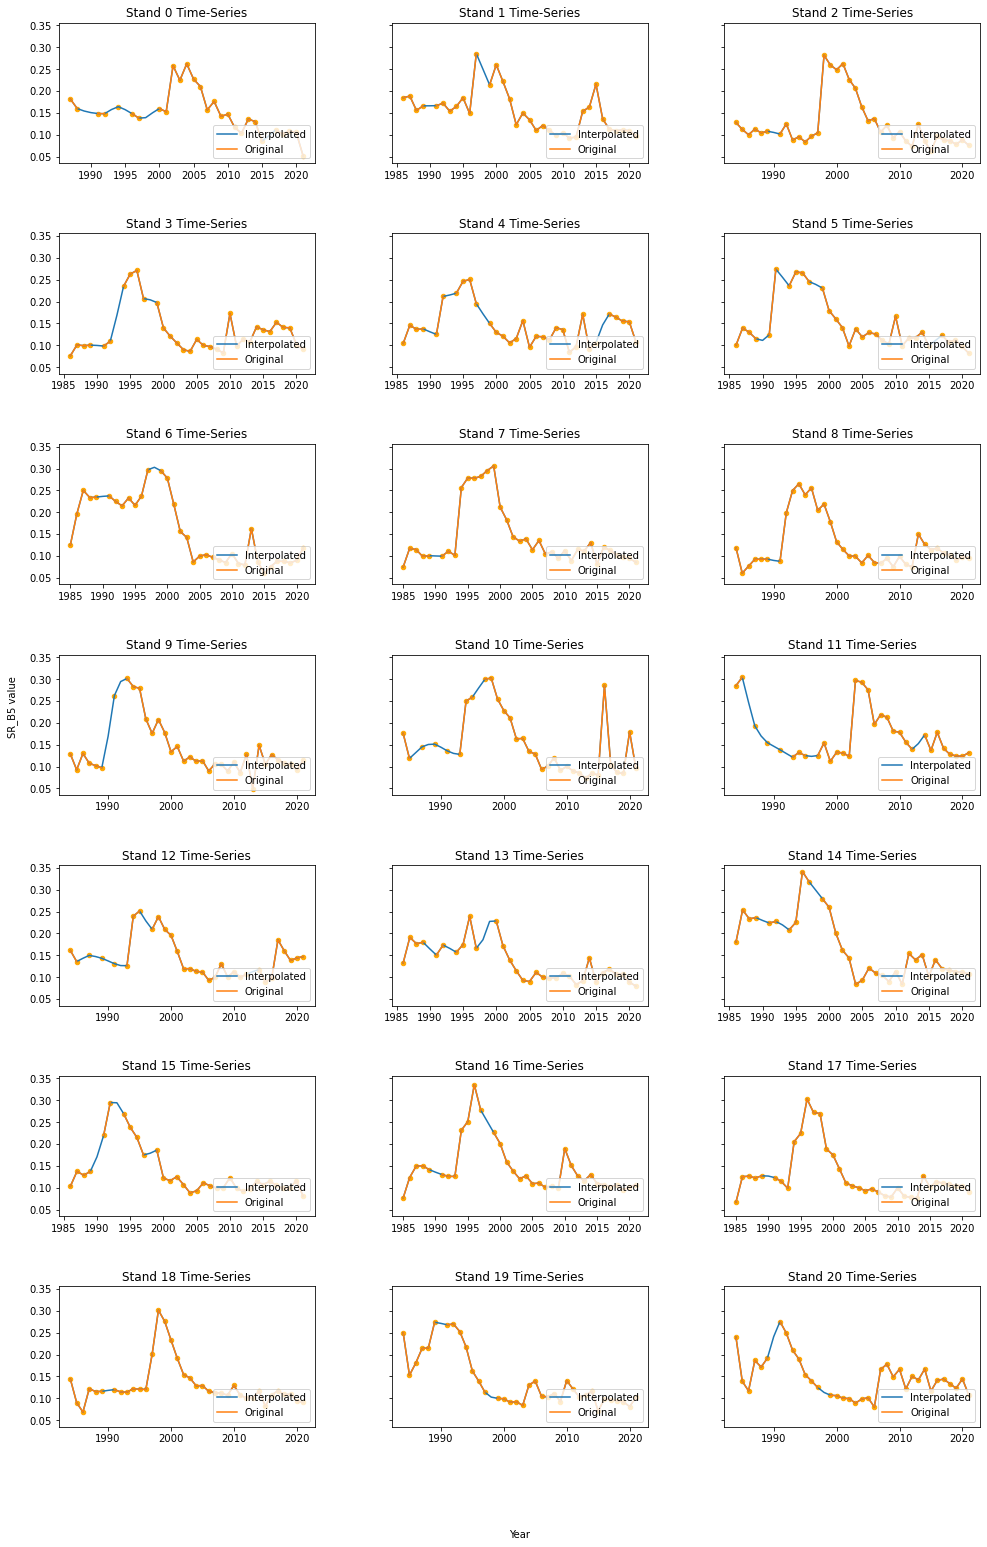

In [54]:
%matplotlib inline
import scipy as sp
import scipy.signal as scisig

## interpolation of null values
plotDF = VItsDF.interpolate(axis = 'columns',method = 'akima')

# setting up for time-series plots
fig, axs = plt.subplots(7, 3, sharex=False, sharey=True, figsize = (16,25))

for i, ax in enumerate(fig.axes):
    ax.plot(plotDF.iloc[i,].transpose(),label = "Interpolated")
    ax.plot(VItsDF.iloc[i,].transpose(),label = "Original")
    ax.scatter(imageYears,VItsDF.iloc[i,], color = 'orange',s = 20)
    ax.legend(loc='lower right')
    ax.set_title("Stand"+' '+str(standIDs[i])+' '+"Time-Series")
    
fig.subplots_adjust(left=0.1, bottom=0.1, right=None, top=None, wspace=0.3, hspace=0.5)
fig.text(0.5, 0.04, 'Year', ha='center', va='center')
fig.text(0.06, 0.5, (outputIndex+' '+'value'), ha='center', va='center', rotation='vertical')

fig.savefig("C:/R_workspace/timeSeries_interpolation.svg")

In [55]:
plotDF

plotDF.to_csv(path_or_buf="C:/R_workspace/Collection2_data/"+outputIndex+"_timeSeries"+today+".csv", sep=',', na_rep='', float_format=None, header=True, index=True, mode='w')

### Reformatting and Writing Phenology Data

In [ ]:
# Importing the data exported in the above cell
importMetrics = pd.read_csv("C:\R_workspace\PhenologyMetrics_values_2022_07_14.csv")

In [ ]:
# reformatting above values into dataframe (one row for each stand, 38 columns for each year)

standIDs = np.sort(importMetrics.iloc[:,0].unique())
numYears = 19
imageYears = range(2001,2001+numYears)
                   
# Creating the dataframe
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
seasonLengthTsDF = pd.DataFrame(index = standIDs, columns = imageYears)
midSeasonLengthTsDF = pd.DataFrame(index = standIDs, columns = imageYears)
PeakDayTsDF = pd.DataFrame(index = standIDs, columns = imageYears)
EVI_AreaTsDF = pd.DataFrame(index = standIDs, columns = imageYears)


for stand in standIDs:
    singleStandDF = importMetrics.loc[importMetrics['UniqueID'] == stand]
    seasonLengthTsDF.iloc[stand,:] = singleStandDF['seasonLength']
    midSeasonLengthTsDF.iloc[stand,:] = singleStandDF['midSeasonLength']
    PeakDayTsDF.iloc[stand,:] = singleStandDF['Peak_1']
    EVI_AreaTsDF.iloc[stand,:] = singleStandDF['EVI_Area_1']
    
# Converting the peak day value from days since Jan 1, 1970 to days since Jan 1 of the current year
yearDayLenList = [365,365,365,366]*5
yearDayLenList = yearDayLenList[0:20] # cutting this down to the 19 years

PeakDayTsDF = PeakDayTsDF - 11323 # days between 1/1/1970 & 1/1/2001 (not including 1/1/2001)

for year in imageYears[1:20]:
    yearIndex = imageYears.index(year)
    PeakDayTsDF[year] = PeakDayTsDF[year] - sum(yearDayLenList[0:yearIndex])
    
# for some reason all the columns dtype is 'object' converting to float above wasn't working so I'll just have to convert the columns
# for col in phenoTsDF:
#     phenoTsDF[col] = pd.to_numeric(phenoTsDF[col], errors='coerce')
#seasonLengthTsDF
#midSeasonLengthTsDF
PeakDayTsDF
#EVI_AreaTsDF

In [ ]:
# Exporting the phenology metric dataframes above
seasonLengthTsDF.to_csv(path_or_buf="C:/R_workspace/seasonLength_timeSeriesDF"+today+".csv", sep=',', na_rep='', float_format=None, header=True, index=True, mode='w')
midSeasonLengthTsDF.to_csv(path_or_buf="C:/R_workspace/midSeasonLength_timeSeriesDF"+today+".csv", sep=',', na_rep='', float_format=None, header=True, index=True, mode='w')
PeakDayTsDF.to_csv(path_or_buf="C:/R_workspace/PeakDay_timeSeriesDF"+today+".csv", sep=',', na_rep='', float_format=None, header=True, index=True, mode='w')
EVI_AreaTsDF.to_csv(path_or_buf="C:/R_workspace/EVI2_Area_timeSeriesDF"+today+".csv", sep=',', na_rep='', float_format=None, header=True, index=True, mode='w')